In [ ]:
!pip install tensorflow opencv-python matplotlib
!pip list

In [22]:
import tensorflow as tf
import os
import cv2
import stat
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# if using gpus to run ANN, allocates only certain amount of GPU memory towards ANN
gpu_list = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpu_list:
    tf.config.experimental.set_memory_growth(gpu, True)

Found 562 images belonging to 4 classes.


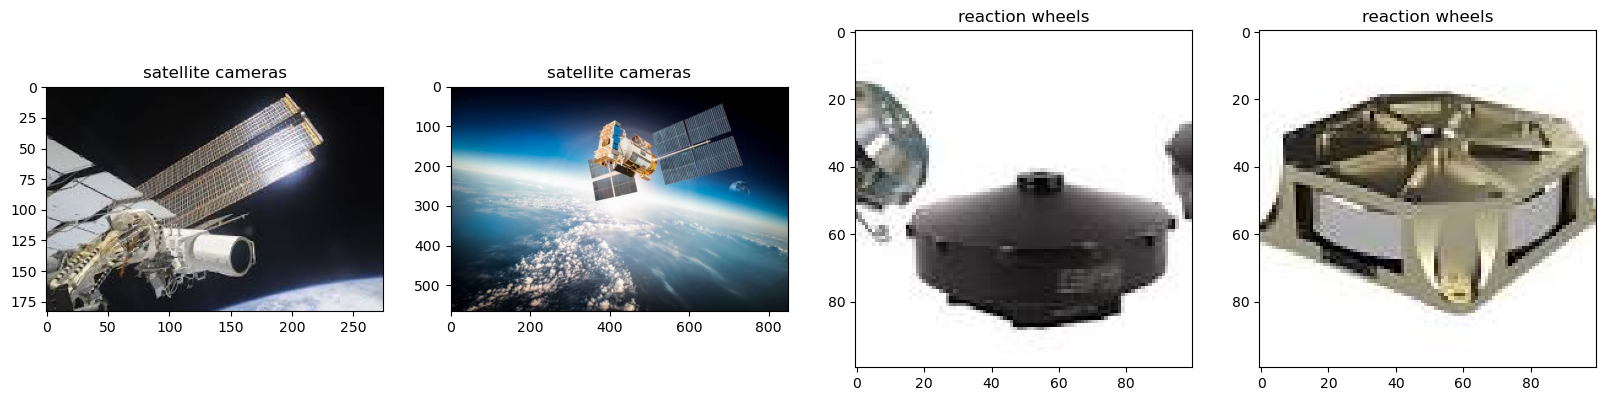

In [23]:
# remove unsupported image files from the directory
img_directory = 'images_satellite_parts'
for img_class in os.listdir(img_directory):
    for img in os.listdir(os.path.join(img_directory, img_class)):
        img_path = os.path.join(img_directory, img_class, img)
        img_type = imghdr.what(img_path)
        if img_type not in ['jpeg', 'jpg', 'png']:
            print('Removing image {}'.format(img_path))
            os.chmod(img_path, stat.S_IWRITE)
            os.remove(img_path)

# creating a dataset to print 4 random images
image_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
data_generator = image_datagen.flow_from_directory(
    img_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True)

# plots the 4 images
class_labels = list(data_generator.class_indices.keys())
plt.figure(figsize = (20, 20))
for i in range(4):
    random_index = np.random.randint(0, len(data_generator.filenames))
    img_path = os.path.join(img_directory, data_generator.filenames[random_index])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(class_labels[int(data_generator.labels[random_index])])
plt.show()

In [24]:
# ImageDataGenerator creation
image_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

# creating training dataset
train_generator = image_datagen.flow_from_directory(
    img_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training',
    shuffle = True)

# creating validation dataset
validation_generator = image_datagen.flow_from_directory(
    img_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = True)

Found 451 images belonging to 4 classes.


Found 111 images belonging to 4 classes.


In [25]:
# building the model
input_layer = Input(shape = (256, 256, 3))
conv_1 = Conv2D(16, (3, 3), 1, activation = 'relu')(input_layer)
batchnorm_1 = BatchNormalization()(conv_1)
maxpool_1 = MaxPooling2D()(batchnorm_1)
conv_2 = Conv2D(32, (3, 3), 1, activation = 'relu')(maxpool_1)
batchnorm_2 = BatchNormalization()(conv_2)
maxpool_2 = MaxPooling2D()(batchnorm_2)
conv_3 = Conv2D(16, (3, 3), 1, activation = 'relu')(maxpool_2)
batchnorm_3 = BatchNormalization()(conv_3)
maxpool_3 = MaxPooling2D()(batchnorm_3)
flatten = Flatten()(maxpool_3)
dropout_1 = Dropout(0.5)(flatten)
dense1 = Dense(64, activation = 'relu')(dropout_1)
dropout_2 = Dropout(0.5)(dense1)
output_layer = Dense(len(train_generator.class_indices), activation = 'softmax')(dropout_2)

model = Model(inputs = input_layer, outputs = output_layer)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_22 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_22 (Ba  (None, 254, 254, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_23 (Ba  (None, 125, 125, 32)      128 

In [26]:
# training the model
trained_model = model.fit(train_generator, epochs = 20, validation_data = validation_generator)

Epoch 1/20
15/15 [==============================] - 16s 999ms/step - loss: 3.6464 - accuracy: 0.2794 - val_loss: 1.3771 - val_accuracy: 0.2973
Epoch 2/20
15/15 [==============================] - 13s 903ms/step - loss: 1.2805 - accuracy: 0.5322 - val_loss: 2.0246 - val_accuracy: 0.2703
Epoch 3/20
15/15 [==============================] - 13s 904ms/step - loss: 0.9786 - accuracy: 0.5854 - val_loss: 3.0947 - val_accuracy: 0.2432
Epoch 4/20
15/15 [==============================] - 13s 882ms/step - loss: 0.8063 - accuracy: 0.6785 - val_loss: 3.0563 - val_accuracy: 0.2793
Epoch 5/20
15/15 [==============================] - 14s 942ms/step - loss: 0.8426 - accuracy: 0.6874 - val_loss: 5.0752 - val_accuracy: 0.2613
Epoch 6/20
15/15 [==============================] - 13s 873ms/step - loss: 0.7506 - accuracy: 0.6918 - val_loss: 5.5455 - val_accuracy: 0.2613
Epoch 7/20
15/15 [==============================] - 14s 925ms/step - loss: 0.7573 - accuracy: 0.7051 - val_loss: 4.7465 - val_accuracy: 0.2613

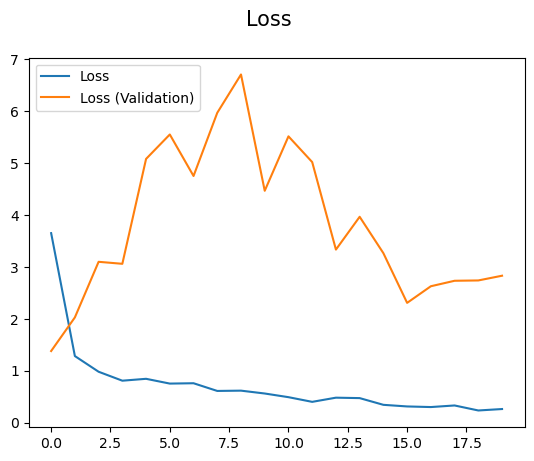

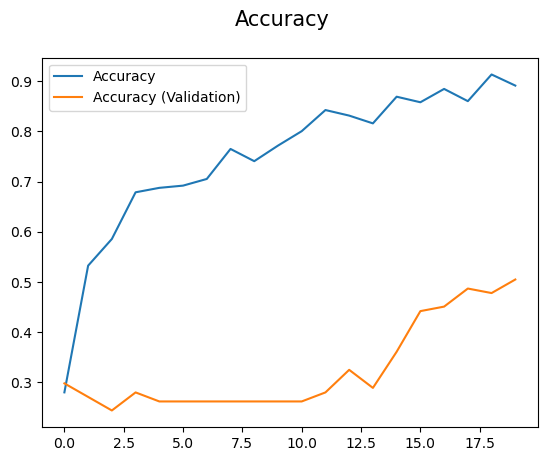

In [27]:
# plotting loss function
fig = plt.figure()
plt.plot(trained_model.history['loss'], label = 'Loss')
plt.plot(trained_model.history['val_loss'], label = 'Loss (Validation)')
fig.suptitle('Loss', fontsize = 15)
plt.legend(loc = "upper left")
plt.show()

# plotting accuracy function
fig = plt.figure()
plt.plot(trained_model.history['accuracy'], label = 'Accuracy')
plt.plot(trained_model.history['val_accuracy'], label = 'Accuracy (Validation)')
fig.suptitle('Accuracy', fontsize = 15)
plt.legend(loc = "upper left")
plt.show()

In [28]:
# evaluating accuracy on the testing set
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

4/4 [==============================] - 4s 1s/step - loss: 2.8270 - accuracy: 0.5045
Test Accuracy: 50.45%


1/1 [==============================] - 0s 263ms/step
Predicted class: deployable booms


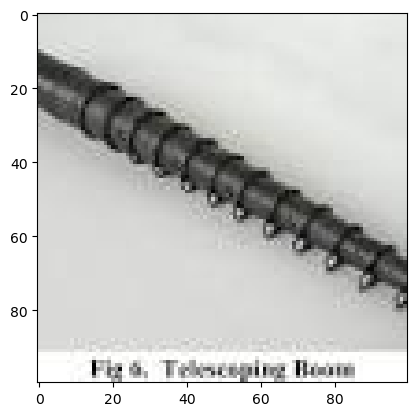

In [29]:
# making predictions on a sample image
test_image_path = "images_satellite_parts\deployable booms\image8.jpeg"
test_image = cv2.imread(test_image_path)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
test_image = tf.image.resize(test_image, (256, 256))
test_image = np.expand_dims(test_image / 255, 0)

predictions = model.predict(test_image)
predicted_class = np.argmax(predictions)
class_labels = list(train_generator.class_indices.keys())

print(f"Predicted class: {class_labels[predicted_class]}")